In [25]:
!cp -r '/content/drive/My Drive/Beta VAE test/dataset' 'data'

In [2]:
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean

In [3]:
def read_skimage(path):
    img = imread(path)
    img = resize(img,(64, 64))
    return img 

In [31]:
np.random.seed(0)
images = []
for _, _, files in os.walk('/content/data/dataset/train'):
  for i,file in enumerate(files):
      if 'jpg' in file:
          print('loading',i,file)
          img = read_skimage('/content/data/dataset/train'+'/'+file)
          images.append(img)

loading 0 2351.jpg
loading 1 954.jpg
loading 2 3787.jpg
loading 3 1439.jpg
loading 4 1475.jpg
loading 5 3242.jpg
loading 6 386.jpg
loading 7 2096.jpg
loading 8 2626.jpg
loading 9 1815.jpg
loading 10 3070.jpg
loading 11 2048.jpg
loading 12 2689.jpg
loading 13 2224.jpg
loading 14 1550.jpg
loading 15 1387.jpg
loading 16 3938.jpg
loading 17 262.jpg
loading 18 1442.jpg
loading 19 3538.jpg
loading 20 3473.jpg
loading 21 2665.jpg
loading 22 1140.jpg
loading 23 1580.jpg
loading 24 3584.jpg
loading 25 877.jpg
loading 26 3403.jpg
loading 27 1680.jpg
loading 28 2148.jpg
loading 29 378.jpg
loading 30 3198.jpg
loading 31 2790.jpg
loading 32 2130.jpg
loading 33 2317.jpg
loading 34 1571.jpg
loading 35 1094.jpg
loading 36 2098.jpg
loading 37 919.jpg
loading 38 1376.jpg
loading 39 2249.jpg
loading 40 2745.jpg
loading 41 2992.jpg
loading 42 2135.jpg
loading 43 629.jpg
loading 44 1920.jpg
loading 45 3852.jpg
loading 46 2141.jpg
loading 47 241.jpg
loading 48 420.jpg
loading 49 1866.jpg
loading 50 1118.jpg

In [32]:
len(images)

3961

In [33]:
import cv2

In [34]:
final_train_data = []
for i in images:
    final_train_data.append(i)
    final_train_data.append(np.fliplr(i).copy())

In [35]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch 
import torchvision
from PIL import Image
import json
import datetime

In [36]:
import numpy as np
import torch 
from datetime import datetime
from torch.utils.data import Dataset
from torch.utils.data.sampler import Sampler
from PIL import Image

    
class Imageset(Dataset):
    """
    Creates image dataset of 32X64 images with 3 channels
    requires numpy and cv2 to work
    """

    def __init__(self, 
                data,
                transform=None):
        print('Loading data')
        self.final_train_data = data
        print('Done Loading Data')

 
        self.transform = transform
        self.length = len(self.final_train_data)
        print('Length', self.length)

        
  
 
    def __getitem__(self, index): 


        if self.transform is not None:
            img = self.transform(self.final_train_data[index])

        return img

    def __len__(self):
        return self.length


In [37]:
transform_chain = transforms.Compose([transforms.ToTensor()])
data = Imageset(final_train_data, transform=transform_chain)
dataloader = torch.utils.data.DataLoader(data, batch_size=16,shuffle=False)

Loading data
Done Loading Data
Length 7922


In [38]:
#visualizations
from torchvision.utils import make_grid

In [39]:
def display_image_grid(x,nrow=8):
    x = (x.cpu().detach()+1.0)*0.5
    x = make_grid(x,nrow=nrow)
    x = x.numpy()
    fig = plt.imshow(np.transpose(x, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [40]:
def loss_fn(recon_x, x, mu, logvar,beta=5.0):
    x = x.to(device,dtype=torch.float)
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    KLD*=beta
    return BCE + KLD, BCE, KLD

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)


class VAE(nn.Module):
    def __init__(self, img_dim=32, image_channels=3, h_dim=1024, z_dim=128, device=None):
        super(VAE, self).__init__()

        assert img_dim == 32 or img_dim == 64 or img_dim == 255, 'img_dim must be 32 or 64 or 255'
        if img_dim == 32:
            self.encoder = nn.Sequential(
                nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(64, 256, kernel_size=4, stride=2),
                nn.ReLU(),
                Flatten()
            ).to(device)

            self.decoder = nn.Sequential(
                UnFlatten(),
                nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),#1x1 -> 5x5
                nn.ReLU(),
                nn.ConvTranspose2d(128, 32, kernel_size=6, stride=2), #5x5 -> 14x14
                nn.ReLU(),
                nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2), #14x14 -> 32x32
                nn.Sigmoid(),
            ).to(device)

        elif img_dim == 64:
            self.encoder = nn.Sequential(
                nn.Conv2d(image_channels, 32, kernel_size=4, stride=2), #64x64 -> 31x31
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=4, stride=2), #31x31 -> 14x14
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=4, stride=2), #14x14 -> 6x6
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=4, stride=2), #6x6 -> 2x2: 4x256=1024
                nn.ReLU(),
                Flatten()
            ).to(device)

            self.decoder = nn.Sequential(
                UnFlatten(),
                nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
                nn.ReLU(),
                nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
                nn.Sigmoid(),
            ).to(device)

        else:
            self.encoder = nn.Sequential(
                nn.Conv2d(image_channels, 8, kernel_size=3, stride=2), #255x255 -> 127x127
                nn.ReLU(),
                nn.Conv2d(8, 16, kernel_size=3, stride=2),  #129x129 -> 63x63
                nn.ReLU(),
                nn.Conv2d(16, 32, kernel_size=3, stride=2),  #63x63 -> 31x31
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=4, stride=2), #31x31 - > 14x14
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=4, stride=2), #14x14 -> 6x6
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=4, stride=2), #6x6 -> 2x2, needs to be output of 2x2 for zdim
                nn.ReLU(),
                Flatten()
            ).to(device)

            self.decoder = nn.Sequential(
                UnFlatten(),
                nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2), #1x1 -> 5x5
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2), #5x5 -> 13x13
                nn.ReLU(),
                nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2), #13x13 -> 29x29
                nn.ReLU(),
                nn.ConvTranspose2d(32, 16,  kernel_size=5, stride=2), #29x29 -> 61x61
                nn.ReLU(),
                nn.ConvTranspose2d(16, 8,  kernel_size=6, stride=2), #61x61 -> 126x126
                nn.ReLU(),
                nn.ConvTranspose2d(8, image_channels,  kernel_size=5, stride=2), #126x126  -> 255x255
                nn.Sigmoid(),
            ).to(device)

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.device = device

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(self.device)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)

        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)

        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        recon_x = self.decode(z)
        return recon_x, z, mu, logvar


In [41]:
import torch.nn.functional as F

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = vae.VAE(img_dim=64,image_channels=3,z_dim=128,device=device).to(device)

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [44]:
import os
filename = 'VAE_Beta150_Beta10.pth'
epochs = 150
bs=16
train = True 
if train:
    epoch = 0
    while epoch < epochs:
        
        for img in iter(dataloader):
            #images = next(iter(training_loader))
            #images = images[0]
            recon_images,z, mu, logvar = model(img.to(device,dtype=torch.float))
            loss, bce, kld = loss_fn(recon_images, img, mu, logvar, beta=10.0) # first beta 5
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                    epochs, loss.item()/bs, bce.item()/bs, kld.item()/bs)
        epoch+=1
        print(to_print)
        

    torch.save(model.state_dict(),  filename)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/150] Loss: 999.010 997.810 1.200
Epoch[2/150] Loss: 998.203 996.835 1.368
Epoch[3/150] Loss: 994.230 992.505 1.725
Epoch[4/150] Loss: 991.207 989.349 1.859
Epoch[5/150] Loss: 989.311 987.416 1.895
Epoch[6/150] Loss: 988.537 986.559 1.977
Epoch[7/150] Loss: 987.065 985.134 1.931
Epoch[8/150] Loss: 985.308 983.253 2.055
Epoch[9/150] Loss: 984.262 982.152 2.110
Epoch[10/150] Loss: 983.960 981.841 2.119
Epoch[11/150] Loss: 983.897 981.692 2.205
Epoch[12/150] Loss: 983.570 981.434 2.136
Epoch[13/150] Loss: 983.095 980.960 2.135
Epoch[14/150] Loss: 982.613 980.458 2.156
Epoch[15/150] Loss: 981.955 979.813 2.143
Epoch[16/150] Loss: 982.398 980.250 2.147
Epoch[17/150] Loss: 982.717 980.592 2.125
Epoch[18/150] Loss: 982.296 980.229 2.067
Epoch[19/150] Loss: 982.119 980.054 2.065
Epoch[20/150] Loss: 982.101 979.999 2.101
Epoch[21/150] Loss: 981.957 979.780 2.177
Epoch[22/150] Loss: 981.576 979.431 2.145
Epoch[23/150] Loss: 981.401 979.224 2.176
Epoch[24/150] Loss: 981.656 979.467 2.189
E

In [45]:
def compare(x):   
    x=x.to(device,dtype=torch.float)
    recon_x,z, _, _ = model(x)
    return torch.cat([x, recon_x])

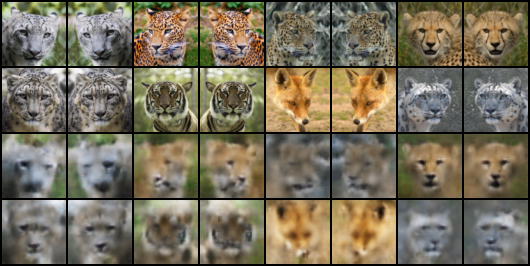

In [46]:
#Beta 10 300 epochs

from IPython.display import Image
from IPython.core.display import Image, display
fixed_x = next(iter(dataloader))
compare_x = compare(fixed_x)
save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png'))

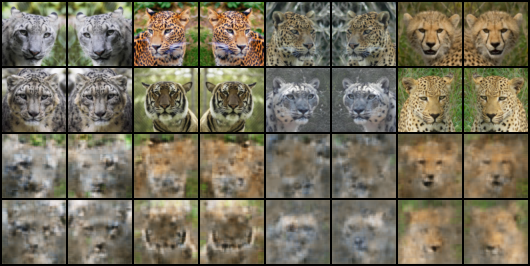

In [24]:
#Beta 10 300 epochs 500 images

from IPython.display import Image
from IPython.core.display import Image, display
fixed_x = next(iter(dataloader))
compare_x = compare(fixed_x)
save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png'))